In [1]:
%pip install numpy~=1.0
%pip install torch -q
%pip install transformers -q
%pip install matplotlib -q

import math
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model_headless = GPT2Model.from_pretrained("gpt2")
model_tied_unembed = GPT2LMHeadModel.from_pretrained("gpt2")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
input_string = "Transformer tokens"
tokens = tokenizer(input_string, return_tensors="pt")
token_ids = tokens.input_ids
print("Input token IDs:", token_ids)

Input token IDs: tensor([[ 8291, 16354, 16326]])


In [3]:
with torch.no_grad():
    outputs = model_tied_unembed(tokens.input_ids, use_cache=False)
logits = outputs.logits
print(logits.shape)

# logits for the last token:
final_token_logits = logits[:, -1, :]
print(final_token_logits.shape)

top_10_logits, top_10_token_indices = torch.topk(final_token_logits, 10, dim=-1)
print('logits\t', top_10_logits)
print('ids\t', top_10_token_indices)

softmax = torch.nn.Softmax(dim=-1)

probs = softmax(top_10_logits)

cold_temp = 0.5
top_10_logits_cold = top_10_logits / cold_temp
probs_cold = softmax(top_10_logits_cold)

hot_temp = 1.5
top_10_logits_hot = top_10_logits / hot_temp
probs_hot = softmax(top_10_logits_hot)

print('\nOutput probability distributions for varying temperature (top-k=10)')
print(f'tok_id\t token\t   T=1.0   T=0.5   T=1.5')
for i in range(10):
    tok_id = top_10_token_indices[0][i]
    token = repr(tokenizer.decode(tok_id))  # using repr() to escape e.g. new lines
    prob = probs[0][i]*100
    prob_cold = probs_cold[0][i]*100
    prob_hot = probs_hot[0][i]*100
    print(f'{tok_id.item()}\t{token:10s}{prob:5.1f}%  {prob_cold:5.1f}%  {prob_hot:5.1f}%')

torch.Size([1, 3, 50257])
torch.Size([1, 50257])
logits	 tensor([[-102.2224, -102.7583, -103.2500, -103.6413, -103.6857, -103.7877,
         -103.8186, -103.8804, -103.8891, -103.9821]])
ids	 tensor([[389,  13,  11, 357, 287, 284, 198, 460, 326, 481]])

Output probability distributions for varying temperature (top-k=10)
tok_id	 token	   T=1.0   T=0.5   T=1.5
389	' are'     29.6%   56.5%   21.6%
13	'.'        17.3%   19.4%   15.1%
11	','        10.6%    7.2%   10.9%
357	' ('        7.2%    3.3%    8.4%
287	' in'       6.8%    3.0%    8.1%
284	' to'       6.2%    2.5%    7.6%
198	'\n'        6.0%    2.3%    7.4%
460	' can'      5.6%    2.1%    7.1%
326	' that'     5.6%    2.0%    7.1%
481	' will'     5.1%    1.7%    6.7%


In [4]:
print(outputs.keys())
outputs

odict_keys(['logits'])


CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[ -27.1873,  -26.1459,  -28.7534,  ...,  -35.2827,  -35.1941,
           -27.1063],
         [ -72.1955,  -68.4561,  -69.9005,  ...,  -80.4494,  -76.7446,
           -70.7487],
         [-107.4842, -106.8489, -110.9719,  ..., -119.1011, -116.9099,
          -108.4834]]]), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)

In [5]:
# autoregressive test
with torch.no_grad():
    full_gen_output = model_tied_unembed.generate(inputs=tokens.input_ids,
                                     attention_mask=tokens.attention_mask,
                                     use_cache=False,
                                     pad_token_id=tokenizer.eos_token_id,
                                     max_length=50)

generated_text = tokenizer.decode(full_gen_output[0])
print(generated_text)

Transformer tokens are not available for use in the game.

The following table lists the tokens that can be used in the game.

Token Name Description 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17


In [6]:
embedding_layer = model_headless.get_input_embeddings()

for i, tok in enumerate(token_ids.flatten()):
    # these are identical...
    embed1 = embedding_layer(tok)
    embed2 = model_headless.wte.weight[tok]
    for e1, e2 in zip(embed1, embed2):
        if e1 != e2:
            print('mismatch!')
    print(f'Token {i+1}: {embed1.shape} min {torch.min(embed1)} max {torch.max(embed1)}')
    print(f'Token {i+1}: {embed2.shape} min {torch.min(embed2)} max {torch.max(embed2)}')

Token 1: torch.Size([768]) min -0.5692750215530396 max 0.3343436121940613
Token 1: torch.Size([768]) min -0.5692750215530396 max 0.3343436121940613
Token 2: torch.Size([768]) min -0.6863736510276794 max 0.3896985948085785
Token 2: torch.Size([768]) min -0.6863736510276794 max 0.3896985948085785
Token 3: torch.Size([768]) min -0.42473170161247253 max 0.6322500109672546
Token 3: torch.Size([768]) min -0.42473170161247253 max 0.6322500109672546


In [7]:
global_min = float('inf')
global_max = float('-inf')

for tok_id in range(50257):
  embed = embedding_layer(torch.tensor(tok_id))
  if torch.min(embed) < global_min:
    global_min = torch.min(embed)
  if torch.max(embed) > global_max:
    global_max = torch.max(embed)
print(global_min, global_max)

tensor(-1.2698, grad_fn=<MinBackward1>) tensor(1.7852, grad_fn=<MaxBackward1>)


In [8]:
token_embeddings = model_headless.wte.weight
position_embeddings = model_headless.wpe.weight

te_min = torch.min(token_embeddings).item()
te_max = torch.max(token_embeddings).item()
te_mean = torch.mean(token_embeddings).item()
pe_min = torch.min(position_embeddings).item()
pe_max = torch.max(position_embeddings).item()
pe_mean = torch.mean(position_embeddings).item()

# format with precision .5f
p = lambda x: f'{x:.5f}'

print('GPT-2 token embeddings:',    token_embeddings.shape)
print(f'min {p(te_min)} max {p(te_max)} mean {p(te_mean)}\n')

print('GPT-2 position embeddings:', position_embeddings.shape)
print(f'min {p(pe_min)} max {p(pe_max)} mean {p(pe_mean)}')

GPT-2 token embeddings: torch.Size([50257, 768])
min -1.26982 max 1.78516 mean 0.00038

GPT-2 position embeddings: torch.Size([1024, 768])
min -4.53811 max 4.06531 mean -0.00068


In [9]:
torch.set_printoptions(sci_mode=False, precision=3)

hex_values = []
for pos, tok in enumerate(token_ids[0]):
    print(f'displaying embeddings for token id {tok} at pos {pos}')
    te = model_headless.wte.weight[tok].detach()
    pe = model_headless.wpe.weight[pos].detach()
    ie = te+pe
    print(f'te: {te[0:9]}')
    print(f'pe: {pe[0:9]}')
    print(f'ie: {ie[0:9]}')
    print(f'input embed min {torch.min(ie)}, input embed max {torch.max(ie)}')

    components = list(range(128-3)) + [-3, -2, -1] # inspect first 125 and last 3

    hex_values.append([])

    for component in components:
        # convert each component's magnitude to a shade of gray

        magnitude = min(max(ie[component].item(), -3), 3)  # floor, ceiling of -3, 3
        normed = (magnitude + 3) / 6
        eight_bit_scale = round(normed * 255)
        # print(f'{component}: {eight_bit_scale}')
        hex_values[pos].append(component)

torch.set_printoptions(profile="default")

displaying embeddings for token id 8291 at pos 0
te: tensor([ 0.129,  0.055,  0.176, -0.061, -0.118,  0.041, -0.217, -0.078, -0.123])
pe: tensor([-0.019, -0.197,  0.004,  0.011,  0.064, -0.105,  0.037, -0.168, -0.049])
ie: tensor([ 0.110, -0.142,  0.180, -0.050, -0.054, -0.064, -0.180, -0.246, -0.173])
input embed min -4.560337543487549, input embed max 3.768101453781128
displaying embeddings for token id 16354 at pos 1
te: tensor([ 0.087, -0.009,  0.285,  0.097, -0.074, -0.266, -0.274, -0.176, -0.077])
pe: tensor([ 0.024, -0.054, -0.095, -0.013, -0.010,  0.031,  0.051,  0.185,  0.044])
ie: tensor([ 0.111, -0.062,  0.190,  0.084, -0.084, -0.235, -0.223,  0.009, -0.033])
input embed min -1.4507211446762085, input embed max 1.5265089273452759
displaying embeddings for token id 16326 at pos 2
te: tensor([ 0.132, -0.019,  0.016, -0.122, -0.229,  0.189, -0.310,  0.018, -0.087])
pe: tensor([ 0.004, -0.085,  0.055, -0.005, -0.026,  0.015,  0.026,  0.059, -0.005])
ie: tensor([ 0.136, -0.103,  

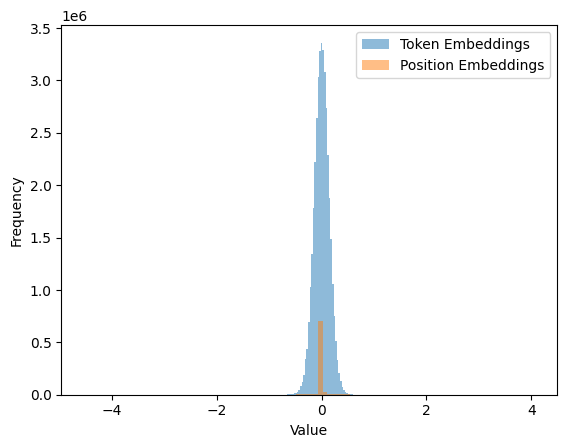

In [10]:
import matplotlib.pyplot as plt

# convert to ndarray
token_values = token_embeddings.detach().numpy().flatten()
position_values = position_embeddings.detach().numpy().flatten()

# histogram
plt.hist(token_values, bins=100, alpha=0.5, label='Token Embeddings')
plt.hist(position_values, bins=100, alpha=0.5, label='Position Embeddings')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [12]:
# for comparison: how high are logits for very obvious predictions?

input_string = "I crawled into bed, closed my eyes, and went to" # sleep: -75, 75%
input_string = "I crawled into bed, closed my eyes, and fell" # asleep: -95, 92%
token_ids = tokenizer(input_string, return_tensors="pt").input_ids

with torch.no_grad():
    outputs = model_tied_unembed(token_ids, use_cache=False)
logits = outputs.logits
final_token_logits = logits[:, -1, :]

top_10_logits, top_10_token_indices = torch.topk(final_token_logits, 10, dim=-1)
print('logits\t', top_10_logits)
print('ids\t', top_10_token_indices)

softmax = torch.nn.Softmax(dim=-1)

probs = softmax(top_10_logits)

cold_temp = 0.5
top_10_logits_cold = top_10_logits / cold_temp
probs_cold = softmax(top_10_logits_cold)

hot_temp = 1.5
top_10_logits_hot = top_10_logits / hot_temp
probs_hot = softmax(top_10_logits_hot)

print('\nOutput probability distributions for varying temperature (top-k=10)')
print(f'tok_id\t token\t       T=1.0   T=0.5   T=1.5')
for i in range(10):
    tok_id = top_10_token_indices[0][i]
    token = repr(tokenizer.decode(tok_id))  # using repr() to escape e.g. new lines
    prob = probs[0][i]*100
    prob_cold = probs_cold[0][i]*100
    prob_hot = probs_hot[0][i]*100
    print(f'{tok_id.item()}\t{token:14s}{prob:5.1f}%  {prob_cold:5.1f}%  {prob_hot:5.1f}%')

logits	 tensor([[ -94.9980,  -98.1901,  -99.6383,  -99.6800,  -99.9885, -100.4567,
         -100.5085, -101.0051, -101.0531, -101.0559]])
ids	 tensor([[16039,   656,   736,   284,   287, 10574,   866, 14917,   319,   625]])

Output probability distributions for varying temperature (top-k=10)
tok_id	 token	       T=1.0   T=0.5   T=1.5
16039	' asleep'      92.4%   99.8%   74.1%
656	' into'         3.8%    0.2%    8.8%
736	' back'         0.9%    0.0%    3.4%
284	' to'           0.9%    0.0%    3.3%
287	' in'           0.6%    0.0%    2.7%
10574	' silent'       0.4%    0.0%    1.9%
866	' down'         0.4%    0.0%    1.9%
14917	' unconscious'  0.2%    0.0%    1.4%
319	' on'           0.2%    0.0%    1.3%
625	' over'         0.2%    0.0%    1.3%


In [13]:
# convince myself temperature scaling before softmax is the same as within softmax
PRECISION = 4
V = [1., 2., 3., 5., -2.]
T = torch.tensor(V)

def softmax(vec, temp=1):
    denominator = sum(math.exp(x / temp) for x in vec)
    return [math.exp(e / temp) / denominator for e in vec]

print('=' * 20, 'Unscaled softmax', '=' * 20)
print('my softmax: ', end='')
print([f"{v:.{PRECISION}f}" for v in softmax(V)])
print('torch smax: ', end='')
print([f'{v.item():.{PRECISION}f}' for v in torch.softmax(T, dim=0)])

for temp in 1, 0.3, 1.85, 10:
    print('=' * 20, 'Temperature', temp, '=' * 20)
    print('prescaling: ', end='')
    print([f'{psv:.{PRECISION}f}' for psv in softmax([v / temp for v in V])])
    print('sftmaxtemp: ', end='')
    print([f'{smt:.{PRECISION}f}' for smt in softmax(V, temp)])
    print('torch smax: ', end='')
    print([f'{tsmt:.{PRECISION}f}' for tsmt in torch.softmax(T / temp, dim=0)])

==================== Unscaled softmax ====================
my softmax: ['0.0152', '0.0413', '0.1124', '0.8303', '0.0008']
torch smax: ['0.0152', '0.0413', '0.1124', '0.8303', '0.0008']
==================== Temperature 1 ====================
prescaling: ['0.0152', '0.0413', '0.1124', '0.8303', '0.0008']
sftmaxtemp: ['0.0152', '0.0413', '0.1124', '0.8303', '0.0008']
torch smax: ['0.0152', '0.0413', '0.1124', '0.8303', '0.0008']
==================== Temperature 0.3 ====================
prescaling: ['0.0000', '0.0000', '0.0013', '0.9987', '0.0000']
sftmaxtemp: ['0.0000', '0.0000', '0.0013', '0.9987', '0.0000']
torch smax: ['0.0000', '0.0000', '0.0013', '0.9987', '0.0000']
==================== Temperature 1.85 ====================
prescaling: ['0.0687', '0.1180', '0.2026', '0.5972', '0.0136']
sftmaxtemp: ['0.0687', '0.1180', '0.2026', '0.5972', '0.0136']
torch smax: ['0.0687', '0.1180', '0.2026', '0.5972', '0.0136']
==================== Temperature 10 ====================
prescaling: ['0.17